In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

In [2]:
data = pd.read_csv('../../../data/kc_house_data_binned.csv')

<AxesSubplot:>

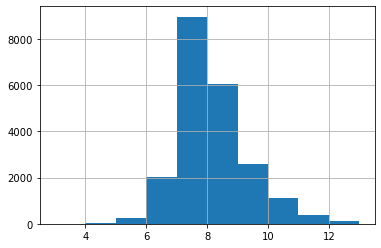

In [3]:
data['grade'].hist()

In [4]:
data = data.loc[(data['grade']>6)&(data['grade']<9)]

In [5]:
to_square = ['median_prce','years_since_new','long','sqft_lot']
for col in to_square:
    data[col+'_man_sq'] = data[col]**2

In [6]:
data['median_prce_comfort_index_man_x'] = data['median_prce']*data['comfort_index']

In [7]:
def relevants(data):
    rel = []
    for col in data.columns:
        if data[col].dtype != object:
            rel.append(col)
    return rel

def graphs(data):
    relevant = relevants(data.drop('price', axis = 1))
    rowsplot = int(len(relevant)/2 + 1)

    fig, axes = plt.subplots(nrows = rowsplot, ncols = 2, figsize=(20, 130))

    for col, ax in zip(relevant, axes.flatten()):
        sns.scatterplot(data = data, x = col, y = 'price', ax = ax)
        ax.set_title(col, fontsize = 20)
        
def make_corrs(data, display = False):
    corrs = data.corr().stack().reset_index()
    corrs = corrs.loc[corrs['level_0'] != corrs['level_1']]
    corrs['pair'] = corrs['level_0'] + ' '+ corrs['level_1']
    corrs['pair'] = corrs['pair'].map(lambda x: ', '.join(sorted(x.split(' '))))
    corrs.drop_duplicates(subset = 'pair', inplace = True)
    corrs.drop(['level_1','level_0'], axis = 1, inplace = True)
    corrs.set_index('pair', inplace = True)
    corrs.columns = pd.Series('correlation')
    corrs = abs(corrs).sort_values('correlation', ascending = False)
    if display:
        display(corrs)
    return corrs

def make_high_corrs(data, display = False):
    corrs = make_corrs(data)
    high_corrs = corrs.loc[corrs['correlation']>= 0.75]
    if display:
        display(high_corrs)
    return high_corrs

def make_corrs_with_price(data, display = False):
    corrs = make_corrs(data)
    corrs_with_price = corrs.loc[corrs.index.str.contains('price')]
    if display:
        display(corrs_with_price)
    return corrs_with_price

def check_homoscedastic(data, display = False):
    results = []
    for col in data.drop('price', axis = 1).columns:
        lower = data[col].quantile(0.45)
        upper = data[col].quantile(0.55)
        mids = data.loc[(data[col] >= lower)&(data[col] <= upper)].index

        index = [x for x in data.index if x not in mids]
        formula = f'price~{col}'
        model = smf.ols(formula = formula, data = data).fit()

        results.append((col, sms.het_goldfeldquandt(model.resid.iloc[index], model.model.exog[index])[1]))

    heteroscedastic = [(col, p) for col, p in results if p < 0.05]
    if display:
        print(heteroscedastic)
    
    return heteroscedastic, results

def corr(x, y):
    xbar = x.mean()
    ybar = y.mean()
    return sum((x-xbar)*(y-ybar))/np.sqrt(sum((x-xbar)**2)*sum((y-ybar)**2))



In [8]:
poly = PolynomialFeatures(2)
data_cop = data.drop(['price','date','zipcode','datefloat','act_prce','id'], axis = 1)
poly.fit(data_cop)
X = pd.DataFrame(poly.transform(data_cop), columns = poly.get_feature_names(data_cop.columns), index = data_cop.index)
y = data['price']
print(len(X.columns))
linreg = LinearRegression()

1225


In [9]:
print(X.columns)

Index(['1', 'sqft_lot', 'waterfront', 'grade', 'sqft_above', 'sqft_basement',
       'yr_built', 'yr_renovated', 'lat', 'long',
       ...
       'years_since_new_man_sq^2', 'years_since_new_man_sq long_man_sq',
       'years_since_new_man_sq sqft_lot_man_sq',
       'years_since_new_man_sq median_prce_comfort_index_man_x',
       'long_man_sq^2', 'long_man_sq sqft_lot_man_sq',
       'long_man_sq median_prce_comfort_index_man_x', 'sqft_lot_man_sq^2',
       'sqft_lot_man_sq median_prce_comfort_index_man_x',
       'median_prce_comfort_index_man_x^2'],
      dtype='object', length=1225)


In [10]:
categoricals = ['bedrooms','bathrooms','floors','waterfront','view','condition','renovated']

In [11]:
dropped = 0
for cat in categoricals:
    cols = X.columns[X.columns.str.contains(cat)]
    for col in cols:
        if len(col.split(' ')) == 2:
            factors = col.split(' ')
            if factors[0].split('_')[0] == factors[1].split('_')[0]:
                print(f'Removing {col}', end = '--')
                dropped += 1
                X.drop(col, axis = 1, inplace = True)
                
        else:
            if '^' in col:
                print(f'Removing {col}', end = '--')
                dropped += 1
                X.drop(col, axis = 1, inplace = True)

Removing bedrooms_few^2--Removing bedrooms_few bedrooms_norm--Removing bedrooms_few bedrooms_many--Removing bedrooms_norm^2--Removing bedrooms_norm bedrooms_many--Removing bedrooms_many^2--Removing bathrooms_few^2--Removing bathrooms_few bathrooms_norm--Removing bathrooms_few bathrooms_many--Removing bathrooms_norm^2--Removing bathrooms_norm bathrooms_many--Removing bathrooms_many^2--Removing floors_low^2--Removing floors_low floors_norm--Removing floors_low floors_many--Removing floors_norm^2--Removing floors_norm floors_many--Removing floors_many^2--Removing waterfront^2--Removing view_none^2--Removing view_none view_avg--Removing view_none view_good--Removing view_avg^2--Removing view_avg view_good--Removing view_good^2--Removing condition_awful^2--Removing condition_awful condition_avg--Removing condition_awful condition_good--Removing condition_avg^2--Removing condition_avg condition_good--Removing condition_good^2--Removing yr_built yr_renovated--Removing yr_renovated^2--Removing

In [12]:
dropped

34

In [13]:
X.columns

Index(['1', 'sqft_lot', 'waterfront', 'grade', 'sqft_above', 'sqft_basement',
       'yr_built', 'yr_renovated', 'lat', 'long',
       ...
       'years_since_new_man_sq^2', 'years_since_new_man_sq long_man_sq',
       'years_since_new_man_sq sqft_lot_man_sq',
       'years_since_new_man_sq median_prce_comfort_index_man_x',
       'long_man_sq^2', 'long_man_sq sqft_lot_man_sq',
       'long_man_sq median_prce_comfort_index_man_x', 'sqft_lot_man_sq^2',
       'sqft_lot_man_sq median_prce_comfort_index_man_x',
       'median_prce_comfort_index_man_x^2'],
      dtype='object', length=1191)

In [14]:
dropped = 0
for col in X.columns:
    if X[col].nunique() == 1:
        X.drop(col, axis = 1, inplace = True)
        dropped+=1

In [15]:
dropped

15

In [16]:
X.columns

Index(['sqft_lot', 'waterfront', 'grade', 'sqft_above', 'sqft_basement',
       'yr_built', 'yr_renovated', 'lat', 'long', 'sqft_living15',
       ...
       'years_since_new_man_sq^2', 'years_since_new_man_sq long_man_sq',
       'years_since_new_man_sq sqft_lot_man_sq',
       'years_since_new_man_sq median_prce_comfort_index_man_x',
       'long_man_sq^2', 'long_man_sq sqft_lot_man_sq',
       'long_man_sq median_prce_comfort_index_man_x', 'sqft_lot_man_sq^2',
       'sqft_lot_man_sq median_prce_comfort_index_man_x',
       'median_prce_comfort_index_man_x^2'],
      dtype='object', length=1176)

In [17]:
folds = KFold(n_splits = 5, shuffle = True)
from sklearn.metrics import r2_score, mean_squared_error
rmse = lambda y, yhat: mean_squared_error(y, yhat, squared = False)
def five_fold(X, y, say = False):
    if say:
        print('KFOLDS')
    trains = []
    tests = []
    count = 0
    for tr_ind, te_ind in folds.split(X):
        X_train, X_test = X.iloc[tr_ind], X.iloc[te_ind]
        y_train, y_test = y.iloc[tr_ind], y.iloc[te_ind]
        if len(np.array(X_train).shape) != 1:
            linreg.fit(X_train, y_train)
            trains.append(linreg.score(X_train, y_train))
            tests.append(linreg.score(X_test, y_test))
        else:
            X_train = np.array(X_train).reshape(-1,1)
            X_test = np.array(X_test).reshape(-1,1)
            linreg.fit(X_train, y_train)
            trains.append(linreg.score(X_train, y_train))
            tests.append(linreg.score(X_test, y_test))
        count +=1

    return sum(trains)/5, sum(tests)/5

def five_fold_rmse(X, y, say = False):
    if say:
        print('KFOLDS')
    trains = []
    tests = []
    count = 0
    for tr_ind, te_ind in folds.split(X):
        X_train, X_test = X.iloc[tr_ind], X.iloc[te_ind]
        y_train, y_test = y.iloc[tr_ind], y.iloc[te_ind]
        if len(np.array(X_train).shape) != 1:
            linreg.fit(X_train, y_train)
            trains.append(rmse(np.exp(linreg.predict(X_train)), np.exp(y_train)))
            tests.append(rmse(np.exp(linreg.predict(X_test)), np.exp(y_test)))
        else:
            X_train = np.array(X_train).reshape(-1,1)
            X_test = np.array(X_test).reshape(-1,1)
            linreg.fit(X_train, y_train)
            trains.append(rmse(np.exp(linreg.predict(X_train)), np.exp(y_train)))
            tests.append(rmse(np.exp(linreg.predict(X_test)), np.exp(y_test)))
        count +=1

    return sum(trains)/5, sum(tests)/5

In [18]:
import copy
def find_best(X, y, initial):
    while 1:
        changed = 0
        if len(initial) != 0:
            init_train, init_test = five_fold(X[initial], y)
        else:
            init_train, init_test = 0, 0
        print(initial)
        addition = 0
        added = ''
        for col in X.drop(initial, axis = 1).columns:
            new = copy.copy(initial)
            new.append(col)
            train_sc, test_sc = five_fold(X[new], y)
            if (test_sc > addition) and (test_sc > init_test) and (abs(test_sc - train_sc) < 0.07):
                addition = test_sc
                added = col
        if addition != 0:
            changed = 1
            initial.append(added)
            print(f'Added {added} with score {addition}')
        
        if len(initial) != 0:
            init_train, init_test = five_fold(X[initial], y)
        else:
            init_train, init_test = 0, 0
        print(initial)
        removal = 0
        removed = ''
        for col in initial:
            new = copy.copy(initial)
            new.remove(col)
            if len(new) == 0:
                break
            train_sc, test_sc = five_fold(X[new], y)
            if (test_sc > removal) and (test_sc > init_test) and (abs(test_sc - train_sc) < 0.07):
                removal = test_sc
                removed = col
        if removal != 0:
            changed = 1
            initial.remove(removed)
            print(f'Removed {removed} with score {removal}')
        
        if changed == 0:
            break
    print(initial)
    
def find_best_rmse(X, y, initial):
    while 1:
        changed = 0
        if len(initial) != 0:
            init_train, init_test = five_fold_rmse(X[initial], y)
        else:
            init_train, init_test = 10**20, 10**20
        print(initial)
        addition = 10**20
        added = ''
        for col in X.drop(initial, axis = 1).columns:
            new = copy.copy(initial)
            new.append(col)
            train_sc, test_sc = five_fold_rmse(X[new], y)
            if (test_sc < addition) and (test_sc < init_test):
                addition = test_sc
                added = col
        if addition != 10**20:
            changed = 1
            initial.append(added)
            print(f'Added {added} with score {addition}')
        
        if len(initial) != 0:
            init_train, init_test = five_fold_rmse(X[initial], y)
        else:
            init_train, init_test = 10**20, 10**20
        print(initial)
        removal = 10**20
        removed = ''
        for col in initial:
            new = copy.copy(initial)
            new.remove(col)
            if len(new) == 0:
                break
            train_sc, test_sc = five_fold_rmse(X[new], y)
            if (test_sc < removal) and (test_sc < init_test):
                removal = test_sc
                removed = col
        if removal != 10**20:
            changed = 1
            initial.remove(removed)
            print(f'Removed {removed} with score {removal}')
        
        if changed == 0:
            break
    print(initial)

In [21]:
mid_inits = ['log_sqft_living median_prce_comfort_index_man_x', 'median_prce_comfort_index_man_x^2', 'unemployment view_none', 'grade log_sqft_living', 'years_since_new years_since_new_man_sq', 'waterfront sqft_above', 'lat^2', 'renovated', 'sqft_lot dist', 'log_sqft_living median_prce_man_sq', 'grade^2', 'yr_renovated seasonal', 'condition_awful long_man_sq', 'sqft_living15 bath_per_bed', 'years_since_new_man_sq^2', 'median_age years_since_new', 'bath_per_bed view_good', 'unemployment years_since_new_man_sq', 'sqft_above sqft_lot_man_sq', 'median_age condition_avg', 'skinniness years_since_new_man_sq', 'bath_per_bed^2', 'median_income summer', 'sqft_lot view_none', 'unemployment^2']

In [20]:
find_best(X, y, mid_inits)

['log_sqft_living median_prce_comfort_index_man_x', 'median_prce_comfort_index_man_x^2', 'unemployment view_none', 'grade log_sqft_living', 'years_since_new years_since_new_man_sq', 'waterfront sqft_above', 'sqft_above sqft_living15', 'lat^2', 'renovated', 'sqft_lot dist', 'years_since_new condition_avg', 'log_sqft_living median_prce_man_sq', 'grade^2', 'yr_renovated seasonal', 'condition_awful long_man_sq', 'sqft_living15 bath_per_bed', 'years_since_new_man_sq^2', 'median_age years_since_new', 'bath_per_bed view_good', 'unemployment years_since_new_man_sq', 'sqft_above sqft_lot_man_sq']
Added median_age condition_avg with score 0.802616244198943
['log_sqft_living median_prce_comfort_index_man_x', 'median_prce_comfort_index_man_x^2', 'unemployment view_none', 'grade log_sqft_living', 'years_since_new years_since_new_man_sq', 'waterfront sqft_above', 'sqft_above sqft_living15', 'lat^2', 'renovated', 'sqft_lot dist', 'years_since_new condition_avg', 'log_sqft_living median_prce_man_sq', 

KeyboardInterrupt: 

In [22]:
from sklearn.metrics import r2_score, mean_squared_error
linreg = LinearRegression()
linreg.fit(X[mid_inits], y)
yhat = linreg.predict(X[mid_inits])
r2_score(np.exp(y), np.exp(yhat)), rmse(y, yhat)
# np.exp(yhat), np.exp(y)

(0.7797296282610426, 0.17438936578267977)

<AxesSubplot:ylabel='price'>

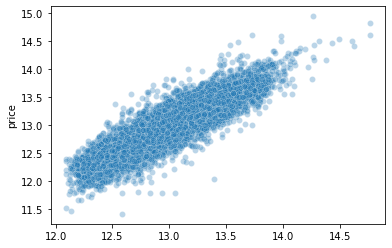

In [24]:
sns.scatterplot(x=yhat, y=y, alpha = 0.3)

<AxesSubplot:ylabel='price'>

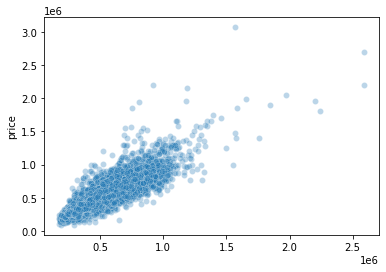

In [23]:
sns.scatterplot(x=np.exp(yhat), y=np.exp(y), alpha = 0.3)